In [2]:
import pandas as pd
import numpy as np
import datetime
import re
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

# Load data

In [ ]:
pellet_path = "."
bout_path = "."

In [ ]:
bout_data = pd.read_csv(bout_path)
pellet_data = pd.read_csv(pellet_path)

## Filter data for only pellet events

In [4]:
condition = pellet_data["Event"] == "Pellet"
filtered_pellet_data = pellet_data[condition]
filtered_pellet_data = pellet_data.loc[:, ["MM:DD:YYYY hh:mm:ss", "Event", "Motor_Turns", "Active_Poke", "Left_Poke_Count", "Right_Poke_Count", "Pellet_Count", "Block_Pellet_Count"]]


### Create new column to represent bout number in pellet_df

In [5]:
def bout_to_dt(str_bout, format_in = "%Y%m%dT%H:%M:%S", format_out="%Y%m%d%H:%M:%S"):
        # Reformat the datetime string according to the specified format
    timestamp_dt = datetime.datetime.strptime(str_bout, format_in)
    return timestamp_dt


filtered_pellet_data["dt"] = filtered_pellet_data["MM:DD:YYYY hh:mm:ss"].apply(lambda row: bout_to_dt(row, format_in = "%m/%d/%Y %H:%M:%S"))
filtered_pellet_data

,MM:DD:YYYY hh:mm:ss,Event,Motor_Turns,Active_Poke,Left_Poke_Count,Right_Poke_Count,Pellet_Count,Block_Pellet_Count,dt
0,7/5/2024 12:34:31,Pellet,6.0,Left,0,0,1,0,2024-07-05 12:34:31
1,7/5/2024 12:36:20,Pellet,1.0,Left,0,0,2,0,2024-07-05 12:36:20
2,7/5/2024 12:36:50,Pellet,6.0,Left,0,0,3,0,2024-07-05 12:36:50
3,7/5/2024 12:36:54,Pellet,6.0,Left,0,0,4,0,2024-07-05 12:36:54
4,7/5/2024 12:37:52,Pellet,1.0,Left,0,0,5,0,2024-07-05 12:37:52
...,...,...,...,...,...,...,...,...,...
501,7/8/2024 8:41:59,Pellet,1.0,Left,2,0,500,0,2024-07-08 08:41:59
502,7/8/2024 9:25:25,Pellet,1.0,Left,2,0,501,0,2024-07-08 09:25:25
503,7/8/2024 9:25:53,Pellet,1.0,Left,2,0,502,0,2024-07-08 09:25:53
504,7/8/2024 9:26:18,Pellet,6.0,Left,2,0,503,0,2024-07-08 09:26:18


In [6]:
bout_data["Bout_Stop"] = bout_data["Bout_Stop"].apply(lambda timestamp: timestamp.strip())

In [7]:
bout_data["Bout_Start"] = bout_data["Bout_Start"].apply(lambda row: bout_to_dt(row))
bout_data["Bout_Stop"] = bout_data["Bout_Stop"].apply(lambda row: bout_to_dt(row))

In [8]:
bout_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Bout_Number       44 non-null     int64         
 1   Bout_Start        44 non-null     datetime64[ns]
 2   Bout_Stop         44 non-null     datetime64[ns]
 3   Pellets_Per_Bout  44 non-null     int64         
 4   IBI               44 non-null     int64         
dtypes: datetime64[ns](2), int64(3)
memory usage: 1.8 KB


In [9]:
def assign_bout_number(pellet_time, bouts_df):
    bout = bouts_df[(bouts_df['Bout_Start'] <= pellet_time) & (bouts_df['Bout_Stop'] >= pellet_time)]
    if not bout.empty:
        return bout['Bout_Number'].values[0]
    else:
        return None

filtered_pellet_data['Bout_Number'] = filtered_pellet_data['dt'].apply(assign_bout_number, bouts_df=bout_data)

In [10]:
filtered_pellet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MM:DD:YYYY hh:mm:ss  506 non-null    object        
 1   Event                506 non-null    object        
 2   Motor_Turns          504 non-null    float64       
 3   Active_Poke          506 non-null    object        
 4   Left_Poke_Count      506 non-null    int64         
 5   Right_Poke_Count     506 non-null    int64         
 6   Pellet_Count         506 non-null    int64         
 7   Block_Pellet_Count   506 non-null    int64         
 8   dt                   506 non-null    datetime64[ns]
 9   Bout_Number          506 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 39.7+ KB


### Calculate Pellets Per Bout

Group by bout number, then sum

In [11]:
def calc_pellet_per_bout(df):
    num_bouts = list(df["Bout_Number"])[-1]

    pellets_per_bout = []
    for i in range(1, num_bouts + 1):
        curr_bout = df[df["Bout_Number"]==i]
        diff = curr_bout["Pellet_Count"].iloc[-1] - curr_bout["Pellet_Count"].iloc[0] - 1
        pellets_per_bout.append(diff)

    return pellets_per_bout

bout_data["Pellets_Consumed"] = calc_pellet_per_bout(filtered_pellet_data)

### Calculating and visualizing pellets consumed

### Bar Chart

Text(0, 0.5, 'Frequency')

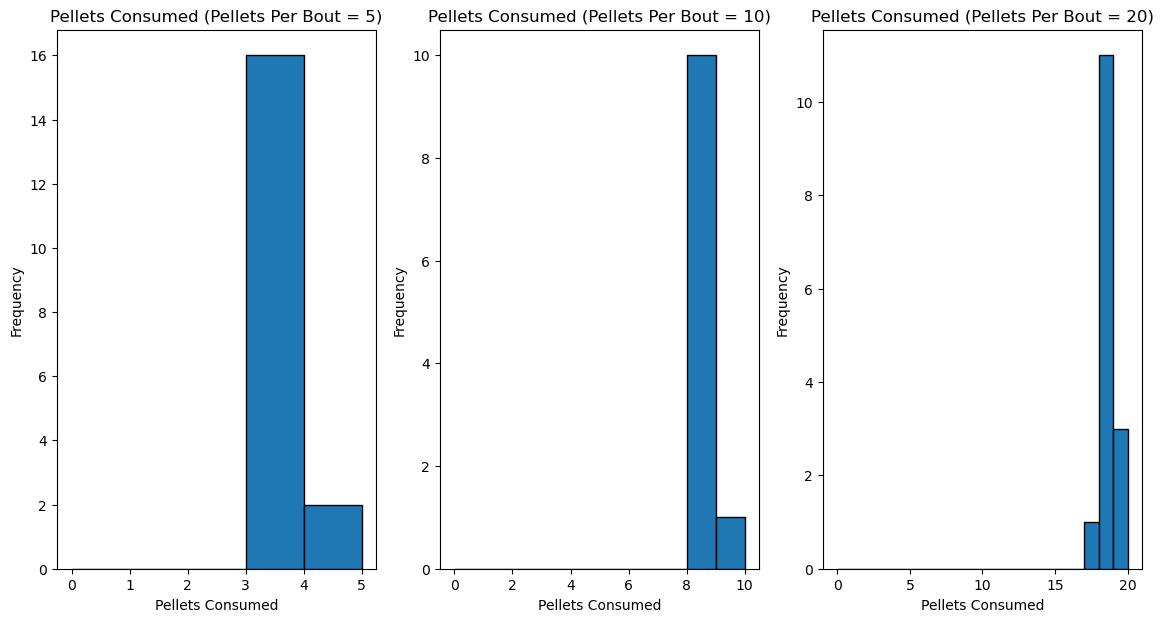

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols= 3, figsize = (14, 7))

bin = range(0,6)

ax[0].hist(bout_data[bout_data["Pellets_Per_Bout"] == 5]["Pellets_Consumed"], bins=bin, edgecolor='black')
ax[0].set_title('Pellets Consumed (Pellets Per Bout = 5)')
ax[0].set_xlabel('Pellets Consumed')
ax[0].set_ylabel('Frequency')

bin = range(0,11)

ax[1].hist(bout_data[bout_data["Pellets_Per_Bout"] == 10]["Pellets_Consumed"], bins=bin, edgecolor='black')
ax[1].set_title('Pellets Consumed (Pellets Per Bout = 10)')
ax[1].set_xlabel('Pellets Consumed')
ax[1].set_ylabel('Frequency')

bin = range(0, 21)

ax[2].hist(bout_data[bout_data["Pellets_Per_Bout"] == 20]["Pellets_Consumed"], bins=bin, edgecolor='black')
ax[2].set_title('Pellets Consumed (Pellets Per Bout = 20)')
ax[2].set_xlabel('Pellets Consumed')
ax[2].set_ylabel('Frequency')

### Lollipop Chart

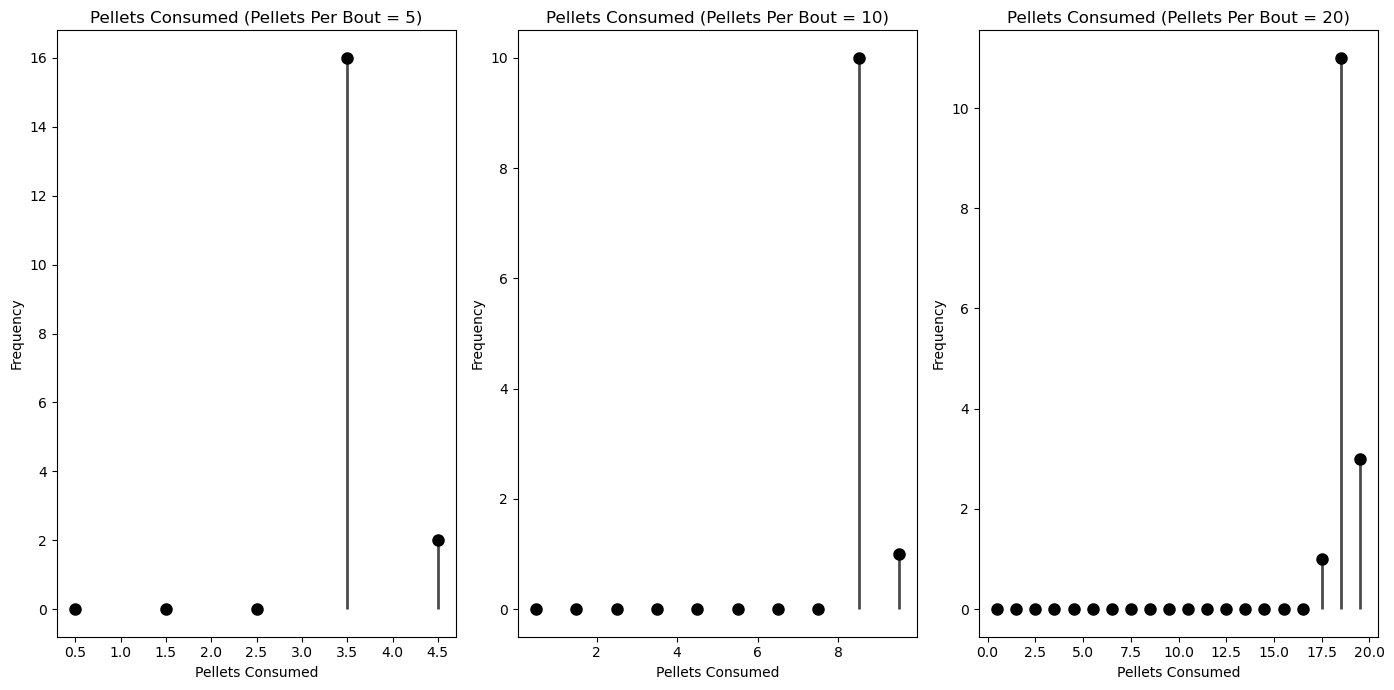

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 7))

# Function to create lollipop chart
def lollipop_chart(ax, data, bins, title):
    hist, bin_edges = np.histogram(data, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    ax.vlines(x=bin_centers, ymin=0, ymax=hist, color='black', alpha=0.7, linewidth=2)
    ax.plot(bin_centers, hist, "o", markersize=8, color='black')
    ax.set_xlim()
    ax.set_title(title)
    ax.set_xlabel('Pellets Consumed')
    ax.set_ylabel('Frequency')

# Plot lollipop charts
lollipop_chart(ax[0], bout_data[bout_data["Pellets_Per_Bout"] == 5]["Pellets_Consumed"], bins=range(0, 6), title='Pellets Consumed (Pellets Per Bout = 5)')
lollipop_chart(ax[1], bout_data[bout_data["Pellets_Per_Bout"] == 10]["Pellets_Consumed"], bins=range(0, 11), title='Pellets Consumed (Pellets Per Bout = 10)')
lollipop_chart(ax[2], bout_data[bout_data["Pellets_Per_Bout"] == 20]["Pellets_Consumed"], bins=range(0, 21), title='Pellets Consumed (Pellets Per Bout = 20)')

plt.tight_layout()
plt.show()

### Plot of fraction of pellets (per bout) consumed over time

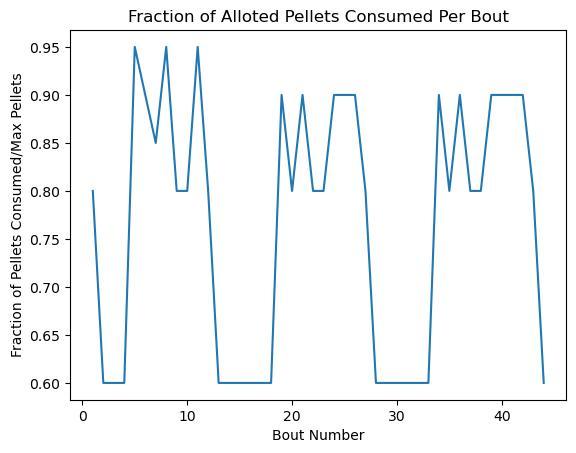

In [14]:
bout_data["Fraction_Consumed"] = bout_data["Pellets_Consumed"]/bout_data["Pellets_Per_Bout"]
bout_data

plt.plot(bout_data["Bout_Number"], bout_data["Fraction_Consumed"])
plt.title("Fraction of Alloted Pellets Consumed Per Bout")

plt.ylabel("Fraction of Pellets Consumed/Max Pellets")
plt.xlabel("Bout Number")

plt.show()

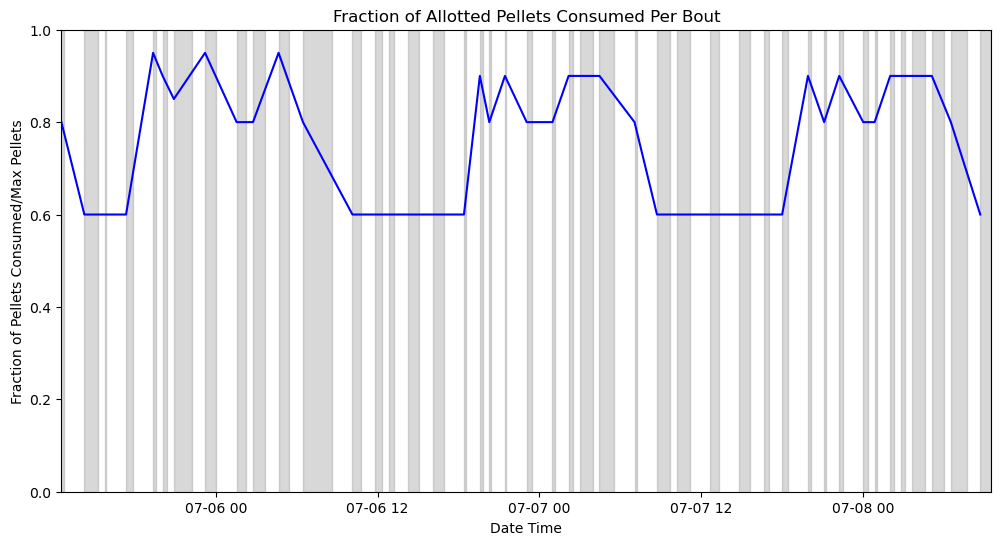

In [15]:

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(bout_data["Bout_Start"], bout_data["Fraction_Consumed"], label='Fraction Consumed', color='blue')

# Shade the bout periods
for i, row in bout_data.iterrows():
    ax.fill_betweenx([0, 1], row['Bout_Start'], row['Bout_Stop'], color='grey', alpha=0.3)

# xlim = (bout_data["Bout_Start"].iloc[0], bout_data["Bout_Stop"].iloc[-1])
ax.set_title("Fraction of Alloted Pellets Consumed Per Bout")

ax.set_xlabel('Date Time')
ax.set_ylabel('Fraction of Pellets Consumed/Max Pellets')
ax.set_title('Fraction of Allotted Pellets Consumed Per Bout')
ax.set_xlim([bout_data["Bout_Start"].iloc[0], bout_data["Bout_Stop"].iloc[-1]])
ax.set_ylim([0, 1])

plt.show()

### Plot of Cumulative Pellets

- Shade bouts
- These are not all full bout lengths

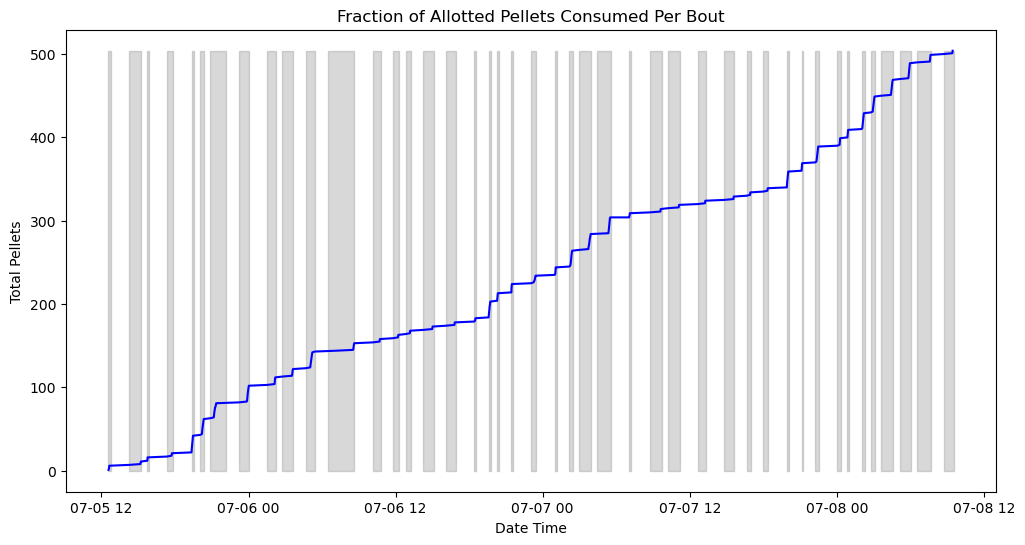

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(filtered_pellet_data["dt"], filtered_pellet_data["Pellet_Count"], label='Fraction Consumed', color='blue')

# Shade the bout periods
for i, row in bout_data.iterrows():
    ax.fill_betweenx([0, filtered_pellet_data["Pellet_Count"].max()], row['Bout_Start'], row['Bout_Stop'], color='grey', alpha=0.3)

ax.set_title("Cumulative Pellets Consumed")

ax.set_xlabel('Date Time')
ax.set_ylabel('Total Pellets')
ax.set_title('Fraction of Allotted Pellets Consumed Per Bout')
# ax.set_xlim([bout_data["Bout_Start"].iloc[0], bout_data["Bout_Stop"].iloc[-1]])

plt.show()

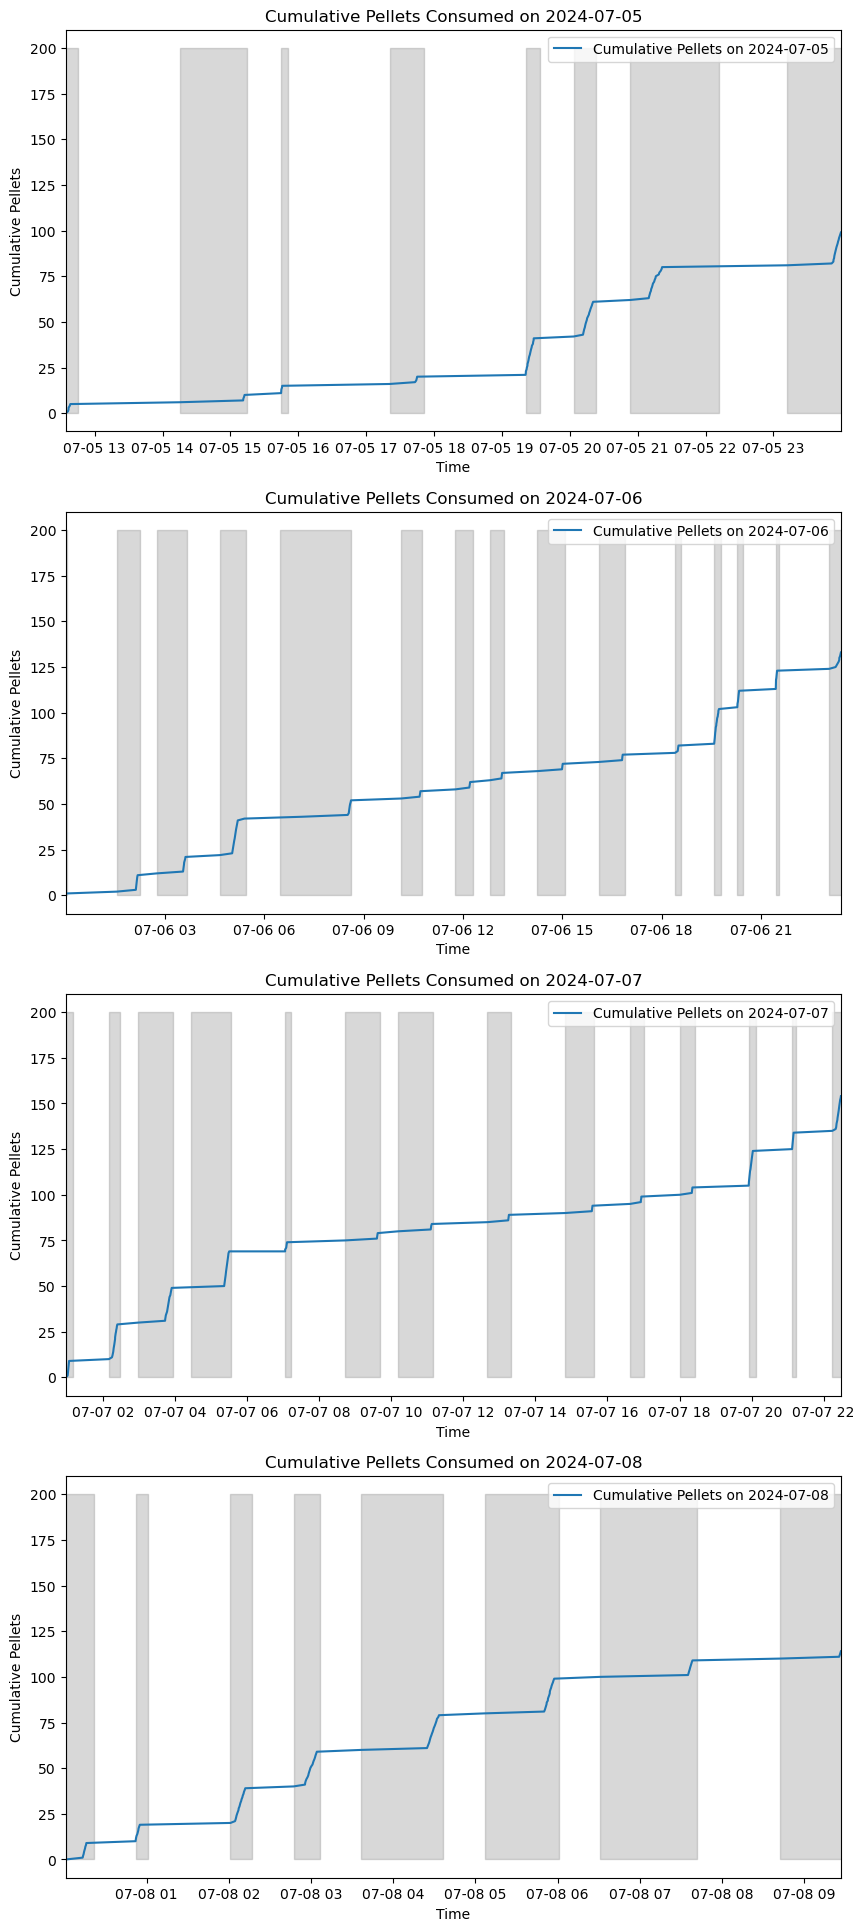

In [23]:
# Extract date
filtered_pellet_data['Date'] = filtered_pellet_data['dt'].dt.date

# Get unique dates
unique_dates = filtered_pellet_data['Date'].unique()

# # Create subplots
num_dates = len(unique_dates)
fig, axes = plt.subplots(nrows=num_dates, ncols=1, figsize=(10, 6 * num_dates), sharex=False)

# Plot cumulative pellets for each date
for i, date in enumerate(unique_dates):
    daily_data = filtered_pellet_data[filtered_pellet_data['Date'] == date]
    reset_pellets = daily_data["Pellet_Count"] - daily_data["Pellet_Count"].min()

    axes[i].plot(daily_data['dt'], reset_pellets, label=f'Cumulative Pellets on {date}')

    for bout in daily_data["Bout_Number"].unique():

        # axes[i].fill_betweenx([0, filtered_pellet_data["Pellet_Count"].max()], bout_data[bout_data["Bout_Number"]==bout]["Bout_Start"], bout_data[bout_data["Bout_Number"]==bout]["Bout_Stop"], color='grey', alpha=0.3)
        axes[i].fill_betweenx([0, 200], bout_data[bout_data["Bout_Number"]==bout]["Bout_Start"], bout_data[bout_data["Bout_Number"]==bout]["Bout_Stop"], color='grey', alpha=0.3)


    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Cumulative Pellets')
    axes[i].set_title(f'Cumulative Pellets Consumed on {date}')
    axes[i].set_xlim([daily_data['dt'].min(), daily_data['dt'].max()])
    axes[i].legend()
